In [4]:
from tdc.single_pred import Tox
data = Tox(name = 'AMES')
# Display the first two rows of the dataset
data.get_data().head(2)

Found local copy...
Loading...
Done!


,Drug_ID,Drug,Y
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccc...,1
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1


In [5]:
# Get the DataFrame
df = data.get_data()

# Print the length of the 'Y' column
print(len(df['Y']))

7278


In [6]:
import pandas as pd

# Convert the Tox object to a DataFrame
data_df = data.get_data()

# Add bins to the 'Y' column
data_df['Y_bins'] = pd.cut(data_df['Y'], bins=[0, 50, float('inf')], labels=['0', '1'])


#label 
# Display the first 2 rows of the DataFrame
#data_df.head(2)

#HISTOGRAM FOR BINS
#import matplotlib.pyplot as plt
#plt.hist(data.get_data()['Y'], bins = 2)
#plt.show()

# Number of entries in each bin
print(data_df['Y_bins'].value_counts())


Y_bins
0    3974
1       0
Name: count, dtype: int64


In [7]:
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns

def get_mol(drug):
    """
    Convert a drug to a molecule object.

    Parameters:
    drug: A string representation of a molecule.

    Returns:
    A molecule object.
    """
    return Chem.MolFromSmiles(drug)

def plot_and_save_histogram(df, y_column, properties, filename):
    """
    Create a histogram for each property in the DataFrame and save the plot.

    Parameters:
    df: The DataFrame containing the data.
    y_column: The name of the column to use for coloring the histogram bars.
    properties: A list of property names to create histograms for.
    filename: The name of the file to save the plot to.
    """
    # Create subplots
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

    # Set the color palette
    sns.set_palette(sns.color_palette("husl", 2))

    # Flatten the axes
    axs = axs.flatten()

    # Loop over properties and axes to create each subplot
    for prop, ax in zip(properties, axs):
        sns.histplot(data=df, x=prop, hue=y_column, kde=True, ax=ax)
        ax.set_title(f'Distribution of {prop}')
        #legend turned off
        ax.get_legend().remove()

    # Adjust the layout
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot
    fig.savefig(filename)

from rdkit.Chem import Descriptors

def add_mol_properties(df, mol_column):
    """
    Add molecular properties to the DataFrame.

    Parameters:
    df: The DataFrame containing the data.
    mol_column: The name of the column containing the molecule objects.

    Returns:
    The DataFrame with added properties.
    """
    
    df['mol_wt'] = df[mol_column].apply(Descriptors.MolWt)
    df['logp'] = df[mol_column].apply(Descriptors.MolLogP)
    df['hba'] = df[mol_column].apply(Descriptors.NumHAcceptors)
    df['hbd'] = df[mol_column].apply(Descriptors.NumHDonors)
    df['tpsa'] = df[mol_column].apply(Descriptors.TPSA)
    df['num_rot_bonds'] = df[mol_column].apply(Descriptors.NumRotatableBonds)
    df['num_het_atoms'] = df[mol_column].apply(Descriptors.NumHeteroatoms)
    df['num_heavy_atoms'] = df[mol_column].apply(Descriptors.HeavyAtomCount)
    df['num_rings'] = df[mol_column].apply(Descriptors.RingCount)
    df['fsp3'] = df[mol_column].apply(Descriptors.FractionCSP3)

    return df

About the dataset:

Half life of a drug is the duration for the concentration of the drug in the body to be reduced by half. It measures the duration of actions of a drug. This dataset is from [1] and we obtain the deposited version under CHEMBL assay 1614674.

Task Description: Regression. Given a drug SMILES string, predict the half life duration.

Dataset Statistics: 667 drugs.

Dataset Split: Random Split Scaffold Split

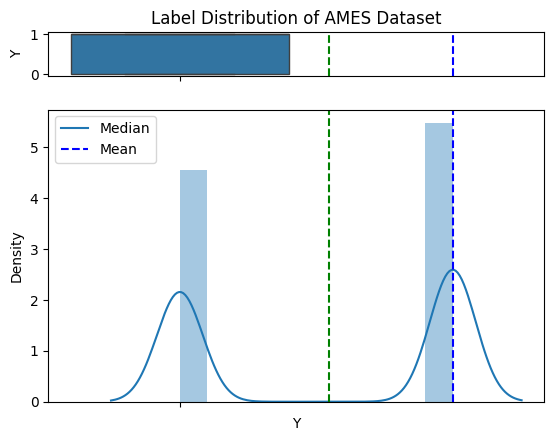

In [8]:
data.label_distribution()

In [9]:
# Convert the Tox object to a DataFrame
data_df = data.get_data()

# Apply the get_mol function to the 'Drug' column
data_df['mol'] = data_df['Drug'].apply(get_mol)

# Add molecular properties to the DataFrame
df = add_mol_properties(data_df, 'mol')

# Corrected lines:
data_df['mol'] = data_df['Drug'].apply(get_mol)
df = add_mol_properties(data_df, 'mol')

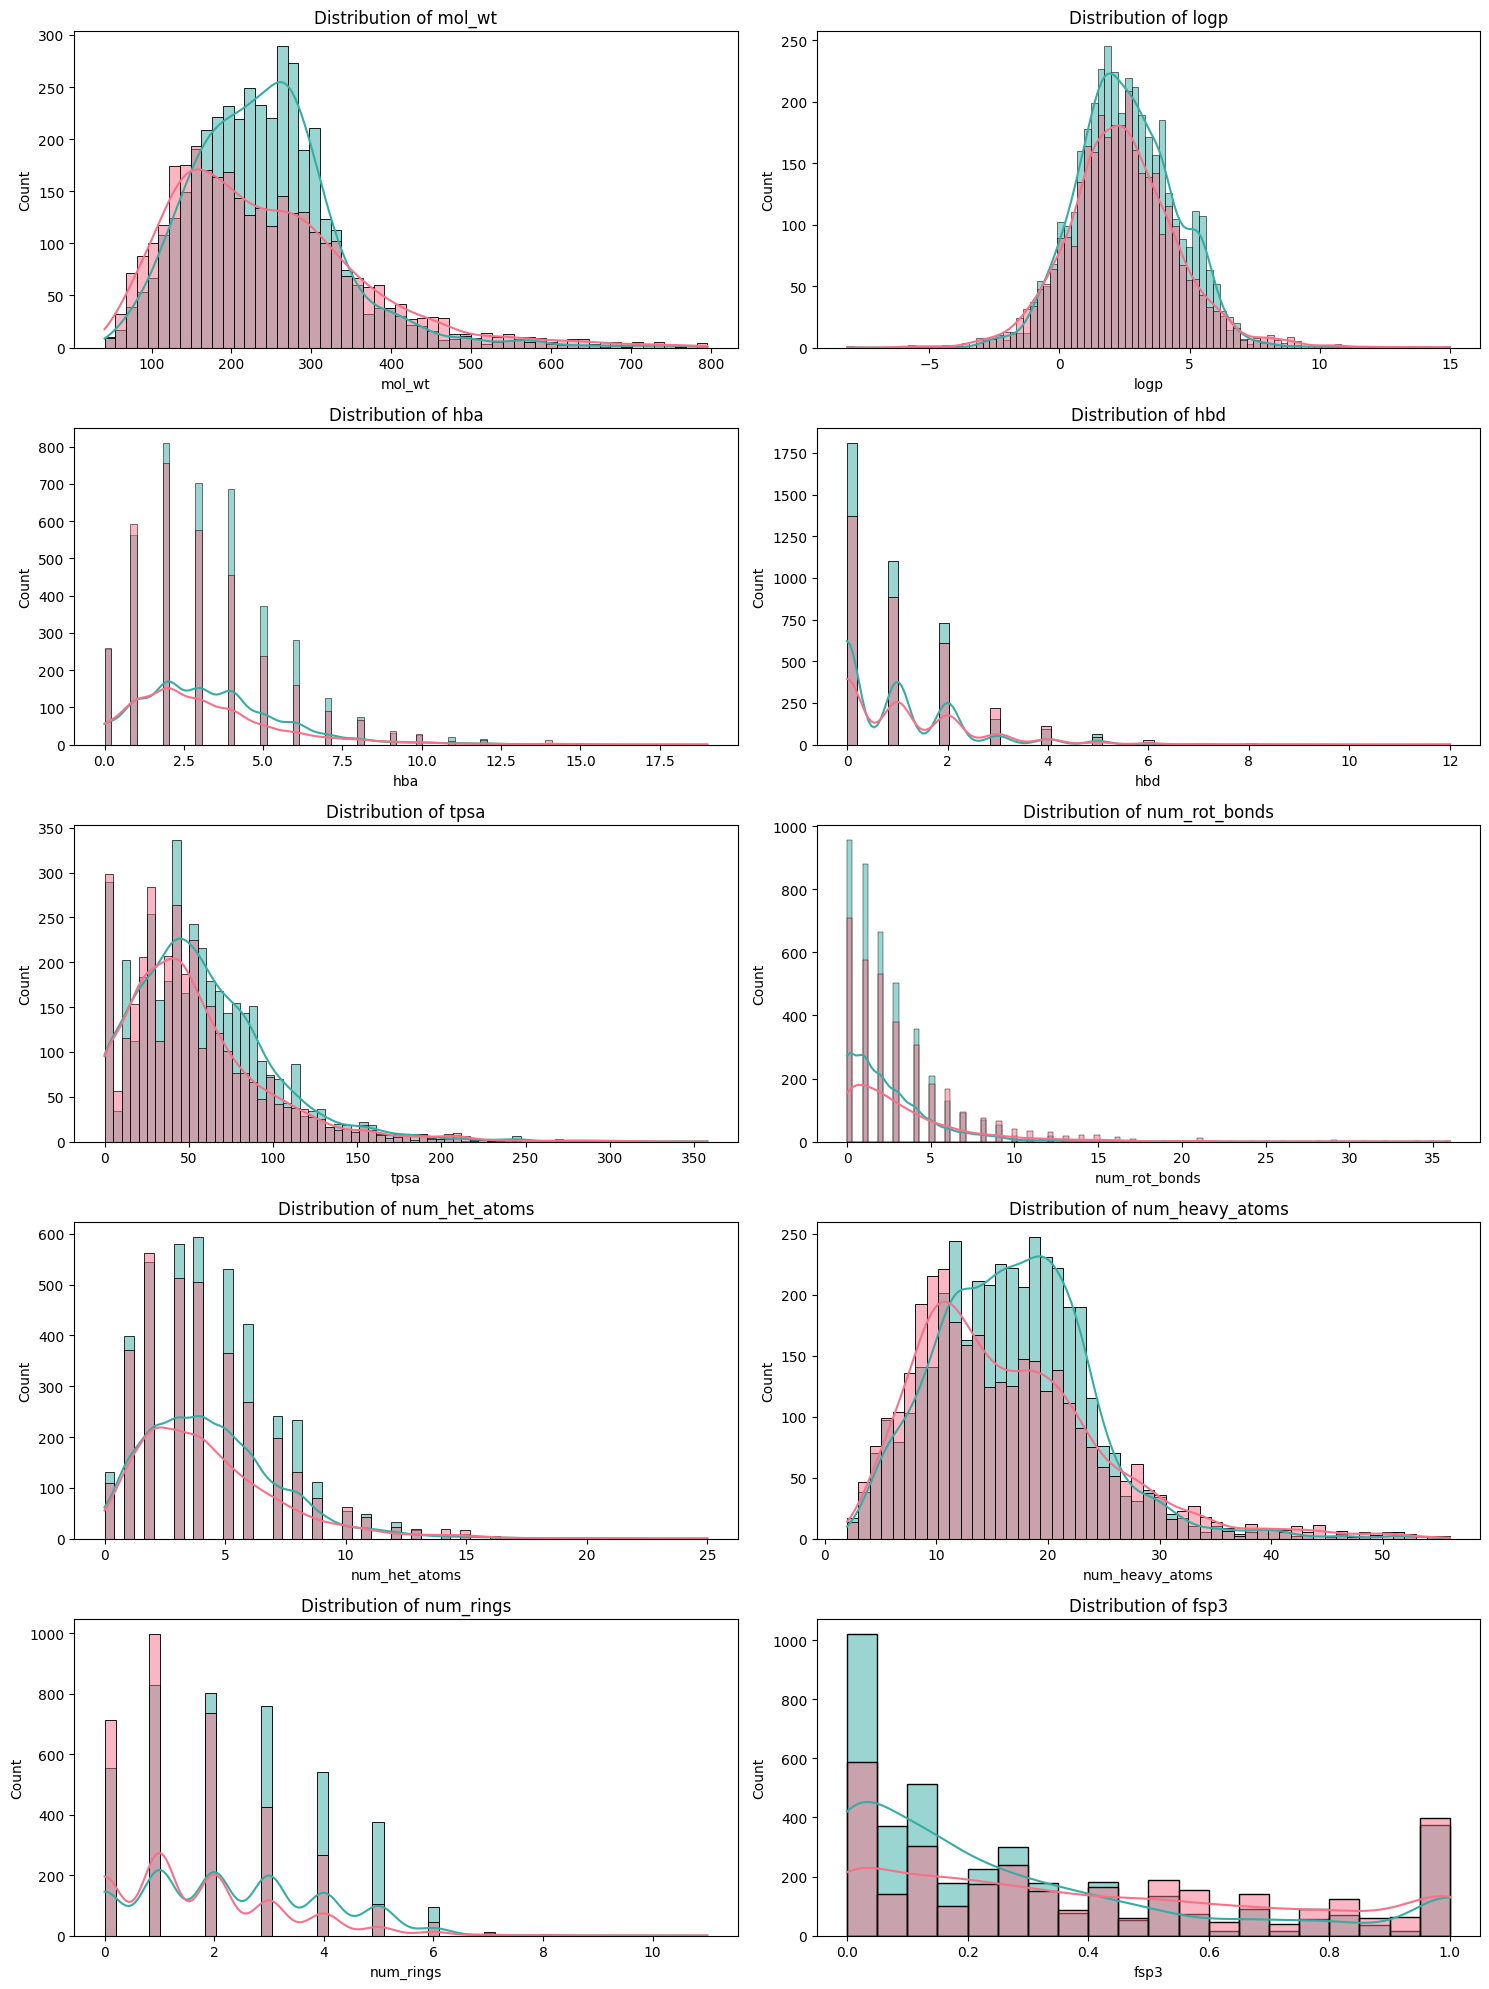

In [10]:
# List of properties
properties = ['mol_wt', 'logp', 'hba', 'hbd', 'tpsa', 'num_rot_bonds', 'num_het_atoms', 'num_heavy_atoms', 'num_rings', 'fsp3']

# Create and save the histogram
plot_and_save_histogram(df, 'Y', properties, 'HERG_distribution.png')


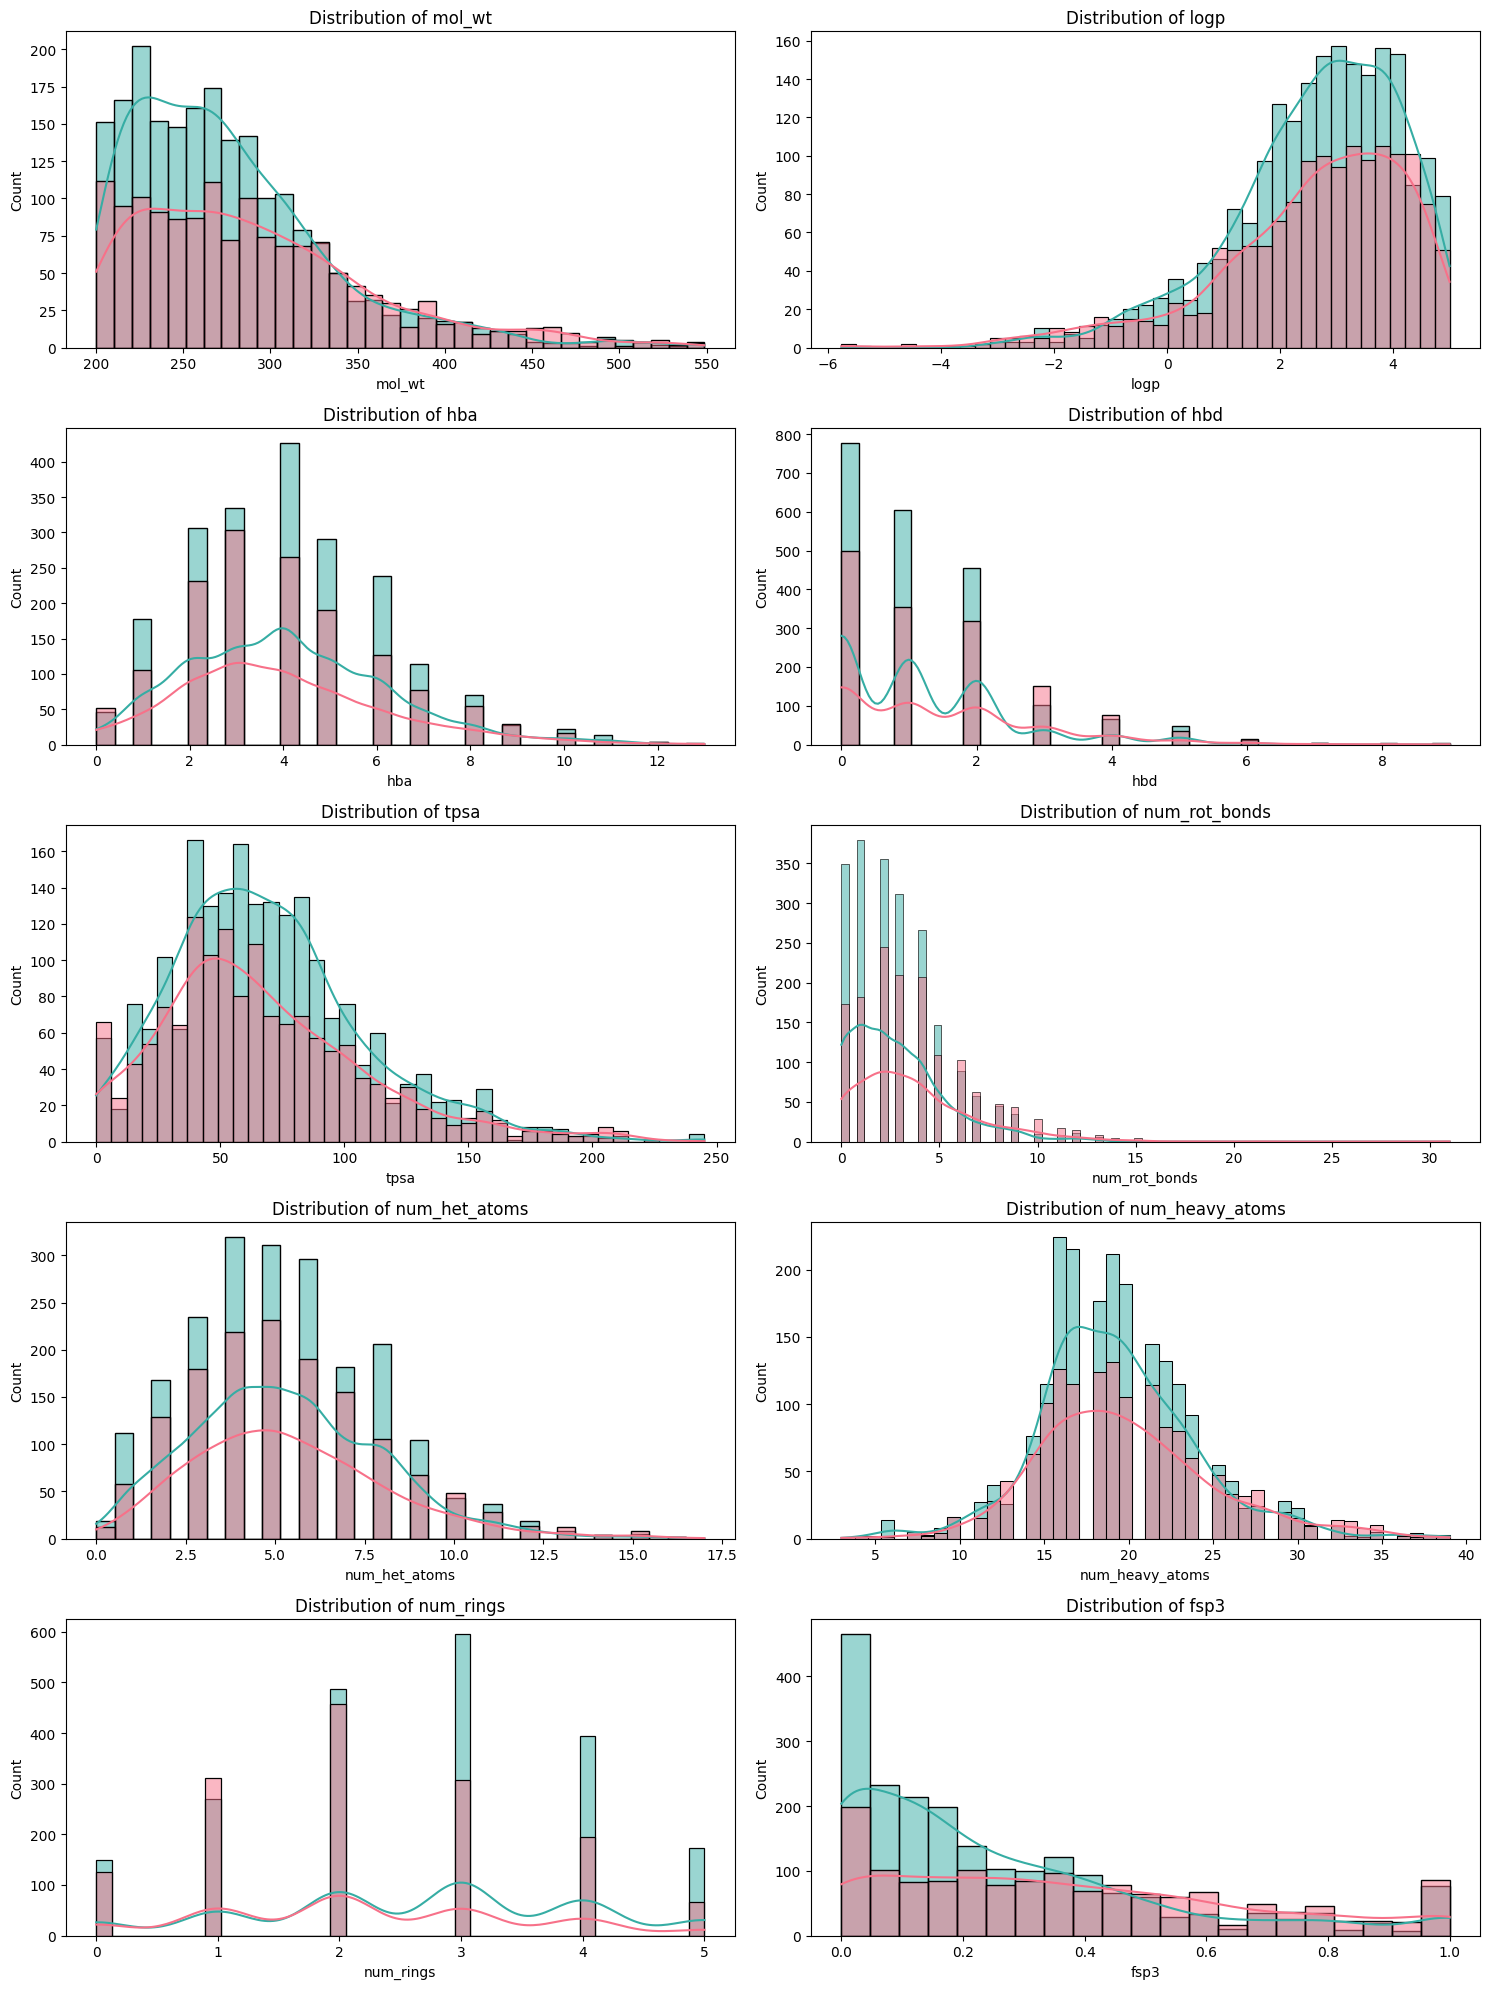

In [11]:
#filter dataset for molecules with molwt > 200 and < 550 and rings < 6
df_filtered = df[(df['mol_wt'] > 200) & (df['mol_wt'] < 550) & (df['num_rings'] < 6) & (df['logp'] < 5) & (df['tpsa'] < 250)]

# List of properties
properties = ['mol_wt', 'logp', 'hba', 'hbd', 'tpsa', 'num_rot_bonds', 'num_het_atoms', 'num_heavy_atoms', 'num_rings', 'fsp3']

# Create and save the histogram
plot_and_save_histogram(df_filtered, 'Y', properties, 'HERG_distribution.png')

In [12]:
#remove salts using rdkit salt remover
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit import Chem

# Create a salt remover object
remover = SaltRemover()

# Apply the salt remover to each molecule
df_filtered['mol_no_salt'] = df_filtered['mol'].apply(remover.StripMol)

df_filtered['mol_no_salt'] = df_filtered['mol_no_salt'].apply(Chem.RemoveHs)

In [13]:
#export the filtered dataset to a csv file
#df_filtered.to_csv('halflife_dataset.csv', index=False)

print("Dataset exported successfully.")

Dataset exported successfully.


In [14]:
#count no of rows and columns with original dataset and dataset final
print(df.shape)
print(df_filtered.shape)

(7278, 14)
(3533, 15)


In [15]:
count = df['Y'].value_counts()
print(count)

Y
1    3974
0    3304
Name: count, dtype: int64


In [16]:
count = df_filtered['Y'].value_counts()
print(count)

Y
1    2070
0    1463
Name: count, dtype: int64
